In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [2]:
# Step 1: Load and preprocess the dataset
df = pd.read_csv("anemia.csv")

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Encode categorical variables
encoder = LabelEncoder()
df['Anaemic'] = encoder.fit_transform(df['Anaemic'])

# Select features for clustering
features = ['Sex', 'Red Pixel', 'Green pixel', 'Blue pixel', 'Hb', 'Anaemic']
X = df[features]

First 5 rows of the dataset:
   Number  Sex  Red Pixel  Green pixel  Blue pixel        Hb Anaemic
0       1    1  43.170845    30.945626   25.921971  6.252659     Yes
1       2    0  43.163481    30.306974   26.759843  8.578865     Yes
2       3    0  46.269997    27.315656   26.028556  9.640936     Yes
3       4    0  45.054787    30.469816   24.460797  4.794217     Yes
4       5    1  45.061884    31.218572   24.071714  8.865329     Yes


In [3]:
# Step 2: Normalize the data (feature scaling)
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

Explained Variance by First 2 PCA Components: 0.7604


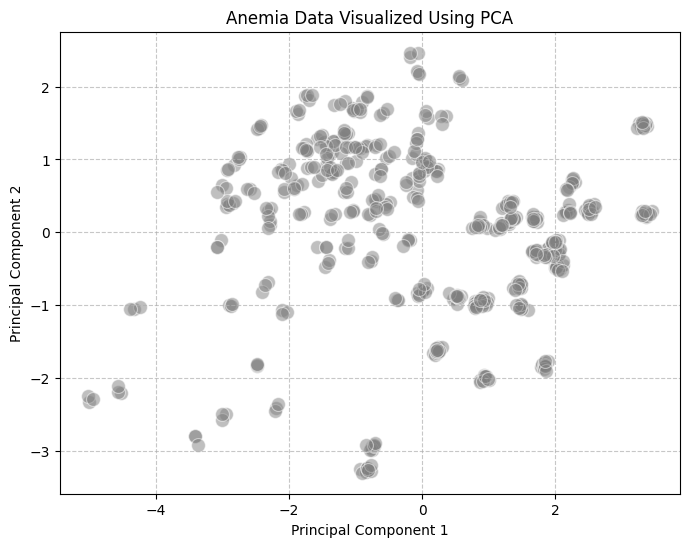

In [4]:
# Step 3: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df)

# Add PCA components to original dataframe
df['PCA1'] = pca_components[:, 0]
df['PCA2'] = pca_components[:, 1]

# Calculate explained variance
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f'Explained Variance by First 2 PCA Components: {explained_variance:.4f}')

# Visualize data using PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', data=df, color='grey', s=100, alpha=0.5)
plt.title('Anemia Data Visualized Using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

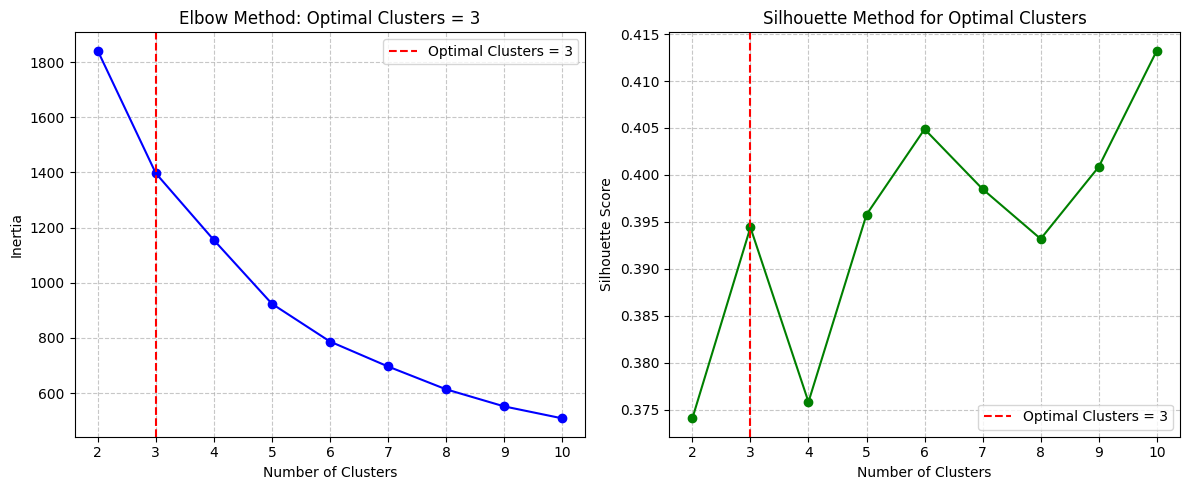

In [5]:
# Step 4: Determine the optimal number of clusters using the Elbow method
inertia_values = []
silhouette_scores = []
cluster_range = range(2, 11)  # Trying from 2 to 10 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    inertia_values.append(kmeans.inertia_)
    
    # Calculate silhouette score for each k
    labels = kmeans.predict(scaled_df)
    silhouette_scores.append(silhouette_score(scaled_df, labels))

# Find the "elbow" point where inertia decreases less significantly
differences = np.diff(inertia_values)
second_differences = np.diff(differences)
optimal_clusters = cluster_range[np.argmax(np.abs(second_differences)) + 1]  # +1 to adjust index

# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title(f'Elbow Method: Optimal Clusters = {optimal_clusters}')
plt.axvline(optimal_clusters, linestyle="--", color='red', label=f'Optimal Clusters = {optimal_clusters}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot Silhouette Method
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='g')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal Clusters')
plt.axvline(optimal_clusters, linestyle="--", color='red', label=f'Optimal Clusters = {optimal_clusters}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
# Step 5: Apply Clustering with the Optimal Number of Clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(scaled_df)

gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(scaled_df)

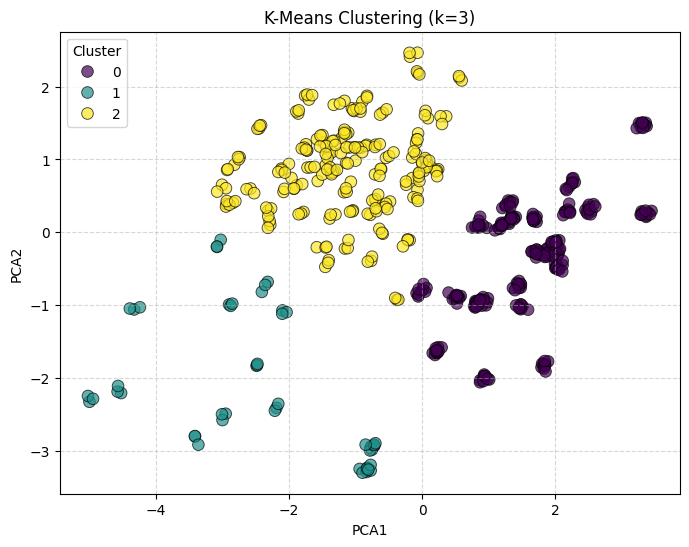

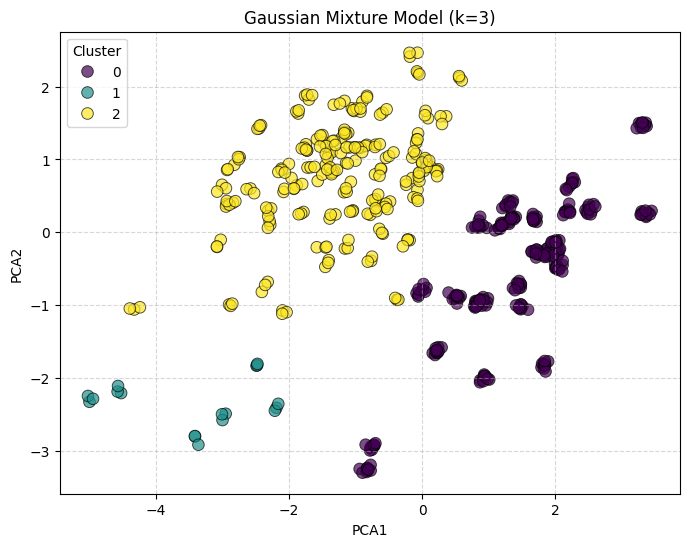

In [7]:
# Step 6: Visualizing the Clusters in PCA Space
def plot_clusters(data, cluster_col, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue=cluster_col, data=data, palette='viridis', s=70, alpha=0.7, edgecolor='k')
    plt.title(title)
    plt.legend(title="Cluster")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

plot_clusters(df, 'kmeans_cluster', f'K-Means Clustering (k={optimal_clusters})')
plot_clusters(df, 'gmm_cluster', f'Gaussian Mixture Model (k={optimal_clusters})')

In [8]:
# Step 7: Evaluate clustering with silhouette score for each method
kmeans_sil_score = silhouette_score(scaled_df, df['kmeans_cluster'])
gmm_sil_score = silhouette_score(scaled_df, df['gmm_cluster'])

In [9]:
# Step 8: Calculate Clustering Error Measures
kmeans_dbi = davies_bouldin_score(scaled_df, df['kmeans_cluster'])
gmm_dbi = davies_bouldin_score(scaled_df, df['gmm_cluster'])

kmeans_chi = calinski_harabasz_score(scaled_df, df['kmeans_cluster'])
gmm_chi = calinski_harabasz_score(scaled_df, df['gmm_cluster'])

gmm_log_likelihood = gmm.score(scaled_df)

In [10]:
# Step 9: Calculate covariance matrix to analyze feature relationships
covariance_matrix = np.cov(scaled_df, rowvar=False)

# Print evaluation metrics
print(f'Silhouette Score for K-Means (k={optimal_clusters}): {kmeans_sil_score:.4f}')
print(f'Silhouette Score for GMM (k={optimal_clusters}): {gmm_sil_score:.4f}')
print(f'Davies-Bouldin Index for K-Means: {kmeans_dbi:.4f}')
print(f'Davies-Bouldin Index for GMM: {gmm_dbi:.4f}')
print(f'Calinski-Harabasz Index for K-Means: {kmeans_chi:.4f}')
print(f'Calinski-Harabasz Index for GMM: {gmm_chi:.4f}')
print(f'Log-Likelihood Score for GMM: {gmm_log_likelihood:.4f}')
print("\nCovariance Matrix:\n", covariance_matrix)

Silhouette Score for K-Means (k=3): 0.3944
Silhouette Score for GMM (k=3): 0.3622
Davies-Bouldin Index for K-Means: 1.0478
Davies-Bouldin Index for GMM: 1.0166
Calinski-Harabasz Index for K-Means: 285.1532
Calinski-Harabasz Index for GMM: 219.9922
Log-Likelihood Score for GMM: 2.2472

Covariance Matrix:
 [[ 1.00200401  0.08138009 -0.14741927  0.0036599   0.21167417 -0.22122274]
 [ 0.08138009  1.00200401 -0.74822692 -0.8369053   0.44756479 -0.40243611]
 [-0.14741927 -0.74822692  1.00200401  0.26351612 -0.68611061  0.6321156 ]
 [ 0.0036599  -0.8369053   0.26351612  1.00200401 -0.08417593  0.06298961]
 [ 0.21167417  0.44756479 -0.68611061 -0.08417593  1.00200401 -0.84153403]
 [-0.22122274 -0.40243611  0.6321156   0.06298961 -0.84153403  1.00200401]]


In [11]:
# Step 10: Calculate Bias Analysis
# Bias in K-Means vs Ground Truth (Anaemic classification)
bias_analysis = pd.DataFrame()
bias_analysis['Anaemic'] = df['Anaemic']
bias_analysis['kmeans_cluster'] = df['kmeans_cluster']
bias_analysis['gmm_cluster'] = df['gmm_cluster']

# Calculate cluster centers
kmeans_centers = kmeans.cluster_centers_
gmm_means = gmm.means_

# Transform back to original feature space
kmeans_centers_original = scaler.inverse_transform(kmeans_centers)
gmm_means_original = scaler.inverse_transform(gmm_means)

# Print cluster centers in original feature space
print("\nK-Means Cluster Centers (Original Features):")
for i, center in enumerate(kmeans_centers_original):
    print(f"Cluster {i}: {center}")

print("\nGMM Cluster Means (Original Features):")
for i, mean in enumerate(gmm_means_original):
    print(f"Cluster {i}: {mean}")


K-Means Cluster Centers (Original Features):
Cluster 0: [ 0.375      43.46266218 30.48905187 26.05410282  8.52012223  1.        ]
Cluster 1: [ 0.41176471 50.72433641 27.98193998 21.2593486  11.9759114   0.35294118]
Cluster 2: [ 0.55760369 45.36797756 28.55083056 26.07970549 13.27994002  0.        ]

GMM Cluster Means (Original Features):
Cluster 0: [ 0.348      43.91602874 30.39106398 25.69654116  8.61636666  1.        ]
Cluster 1: [4.99977544e-01 5.23043833e+01 2.75318937e+01 2.01650500e+01
 1.29084126e+01 1.11022302e-16]
Cluster 2: [ 5.73276704e-01  4.56666498e+01  2.84600279e+01  2.58661736e+01
  1.32876838e+01 -1.11022302e-16]


In [12]:
# Step 11: Analyze clusters based on anemia status (Hb and Anaemic features)
cluster_analysis = df.groupby('kmeans_cluster')[['Hb', 'Anaemic']].mean()
print("\nK-Means Cluster Analysis (Average values):")
print(cluster_analysis)

cluster_analysis_gmm = df.groupby('gmm_cluster')[['Hb', 'Anaemic']].mean()
print("\nGMM Cluster Analysis (Average values):")
print(cluster_analysis_gmm)


K-Means Cluster Analysis (Average values):
                       Hb   Anaemic
kmeans_cluster                     
0                8.520122  1.000000
1               11.975911  0.352941
2               13.279940  0.000000

GMM Cluster Analysis (Average values):
                    Hb  Anaemic
gmm_cluster                    
0             8.616367      1.0
1            12.908212      0.0
2            13.287704      0.0


In [13]:
# Step 12: Analyze cluster characteristics
feature_means = pd.DataFrame()

for i in range(optimal_clusters):
    kmeans_group = df[df['kmeans_cluster'] == i]
    gmm_group = df[df['gmm_cluster'] == i]
    
    # Calculate mean values for each feature by cluster
    feature_means[f'KMeans_C{i}'] = kmeans_group[features].mean()
    feature_means[f'GMM_C{i}'] = gmm_group[features].mean()

print("\nFeature Means by Cluster:")
print(feature_means)


Feature Means by Cluster:
             KMeans_C0     GMM_C0  KMeans_C1     GMM_C1  KMeans_C2     GMM_C2
Sex           0.375000   0.348000   0.411765   0.500000   0.557604   0.573276
Red Pixel    43.462662  43.916029  50.724336  52.304171  45.367978  45.666585
Green pixel  30.489052  30.391064  27.981940  27.532046  28.550831  28.460028
Blue pixel   26.054103  25.696541  21.259349  20.165109  26.079705  25.866239
Hb            8.520122   8.616367  11.975911  12.908212  13.279940  13.287704
Anaemic       1.000000   1.000000   0.352941   0.000000   0.000000   0.000000
